# Adaptive Semantic Communication Analysis

This notebook analyzes the results from the DRL agent simulation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Load Data

In [2]:
csv_path = "runs/results.csv"
try:
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} steps.")
    display(df.head())
except FileNotFoundError:
    print(f"File not found: {csv_path}. Please run the simulation first.\nMake sure you mount the volume correctly so the notebook can see it, or copy the csv here.")
    df = pd.DataFrame()

Loaded 1000 steps.


,step,timestamp,cpu,mem,data_size,action,reward,noise,bandwidth
0,1,1.768186e+09,2.4,24.9,837.37310,SEM_LOCAL,-0.011580,0.04549,11.360271
1,2,1.768186e+09,35.5,25.0,529.07263,SEM_LOCAL,-0.007467,0.04549,11.360271
2,3,1.768186e+09,52.4,25.0,1306.06180,SEM_LOCAL,-0.008204,0.04549,11.360271
3,4,1.768186e+09,50.0,25.0,873.57350,SEM_LOCAL,-0.010660,0.04549,11.360271
4,5,1.768186e+09,57.1,25.0,1604.37160,SEM_LOCAL,-0.024708,0.04549,11.360271


## 2. Reward Analysis

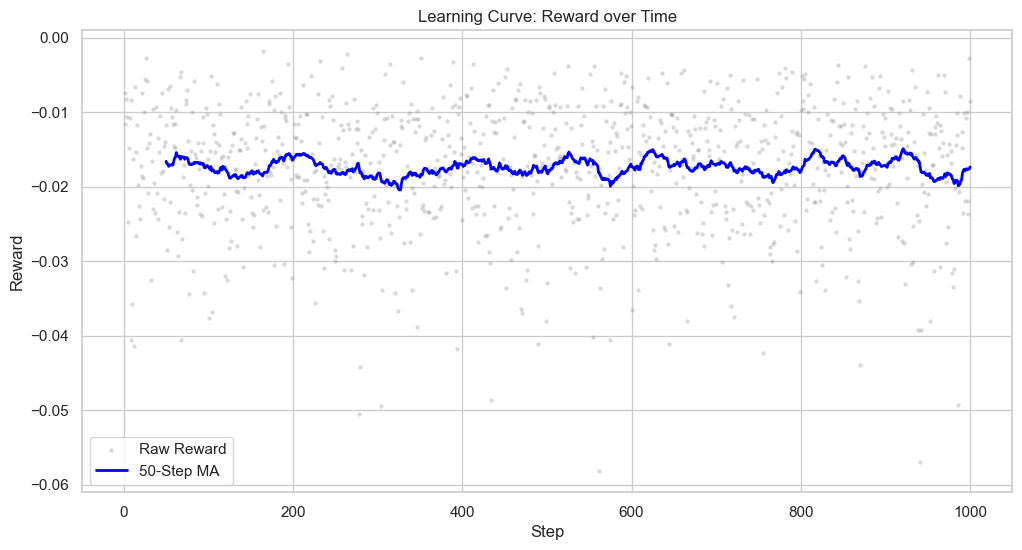

In [3]:
if not df.empty:
    # Calculate Moving Average
    window_size = 50
    df['reward_ma'] = df['reward'].rolling(window=window_size).mean()

    fig, ax1 = plt.subplots()
    
    sns.scatterplot(data=df, x='step', y='reward', alpha=0.3, ax=ax1, label='Raw Reward', color='gray', s=10)
    sns.lineplot(data=df, x='step', y='reward_ma', ax=ax1, label=f'{window_size}-Step MA', color='blue', linewidth=2)
    
    ax1.set_title("Learning Curve: Reward over Time")
    ax1.set_ylabel("Reward")
    ax1.set_xlabel("Step")
    plt.legend()
    plt.show()

## 3. Action Distribution over Time

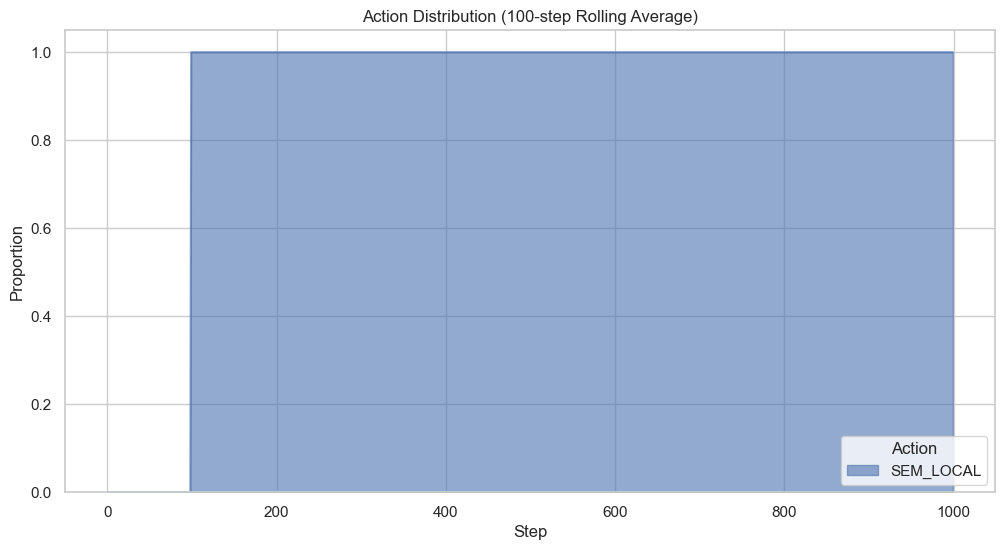

In [4]:
if not df.empty:
    # Convert action strings to categorical if needed, or mapped
    # Assumes action column contains strings like 'SEM_LOCAL', 'RAW'
    
    # Rolling count of actions
    action_dummies = pd.get_dummies(df['action'])
    rolling_actions = action_dummies.rolling(window=100).mean()
    
    rolling_actions.plot.area(alpha=0.6)
    plt.title("Action Distribution (100-step Rolling Average)")
    plt.ylabel("Proportion")
    plt.xlabel("Step")
    plt.legend(title='Action')
    plt.show()

## 4. Policy Behavior: Impact of Network Conditions

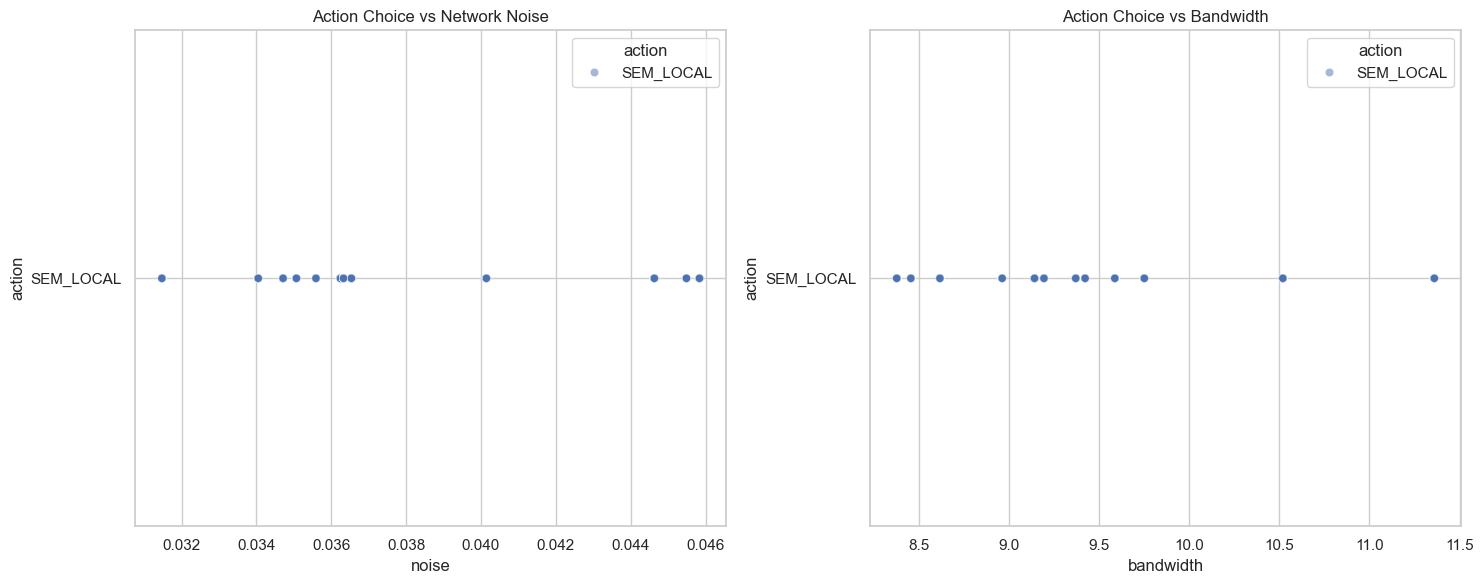

In [5]:
if not df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Noise vs Action
    sns.scatterplot(data=df, x='noise', y='action', hue='action', ax=ax1, alpha=0.5)
    ax1.set_title("Action Choice vs Network Noise")
    
    # Bandwidth vs Action
    sns.scatterplot(data=df, x='bandwidth', y='action', hue='action', ax=ax2, alpha=0.5)
    ax2.set_title("Action Choice vs Bandwidth")
    
    plt.tight_layout()
    plt.show()